# Import Libraries and Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/ForecastFrontiers/Online Retail

/content/drive/MyDrive/ForecastFrontiers/Online Retail


In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# df = pd.read_csv('cleaned_retail_dataset.csv')

# Clustering Methods Comparison

In [ ]:
# Step 1: Read data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

# Step 2: Aggregate by day
daily_sales = df.groupby([pd.Grouper(freq="D"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 3: Split train/test（80%:20%）
split_date = daily_sales.index[int(len(daily_sales) * 0.8)]
train_sales = daily_sales.loc[:split_date].T
test_sales = daily_sales.loc[split_date:].T

# Step 4: Standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_sales)

# Step 5: Clustering
from tqdm import tqdm
results = []
k_range = range(2, 11)

## Kmeans & Agglomerative
for method in ["kmeans", "agglomerative"]:
    for k in k_range:
        if method == "kmeans":
            model = KMeans(n_clusters=k, random_state=42)
        else:
            model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X_train_scaled)
        score = silhouette_score(X_train_scaled, labels)
        results.append({"method": method, "k": k, "silhouette": score})

## DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels = dbscan.fit_predict(X_train_scaled)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
if n_clusters > 1:
    mask = labels != -1
    score = silhouette_score(X_train_scaled[mask], labels[mask])
    results.append({"method": "dbscan", "k": n_clusters, "silhouette": score})

# Result
results_df = pd.DataFrame(results)
results_df.sort_values(by="silhouette", ascending=False, inplace=True)
print(results_df)

           method   k  silhouette
9   agglomerative   2    0.933624
0          kmeans   2    0.794172
12  agglomerative   5    0.771777
11  agglomerative   4    0.771746
10  agglomerative   3    0.771696
2          kmeans   4    0.750019
3          kmeans   5    0.744489
1          kmeans   3    0.738441
5          kmeans   7    0.732006
4          kmeans   6    0.731902
6          kmeans   8    0.724354
18         dbscan   2    0.709780
7          kmeans   9    0.633246
8          kmeans  10    0.633244
14  agglomerative   7    0.621167
13  agglomerative   6    0.621113
17  agglomerative  10    0.609467
16  agglomerative   9    0.609355
15  agglomerative   8    0.608959


In [ ]:
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

# Step 2
weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 3
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
train_weekly_sales = weekly_sales.loc[:split_date].T  # shape: [n_products, n_weeks]

# Step 4
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_weekly_sales)

# Step 5
results = []
k_range = range(2, 11)

# KMeans 和 Agglomerative Clustering
for method in ["kmeans", "agglomerative"]:
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42) if method == "kmeans" else AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X_train_scaled)
        score = silhouette_score(X_train_scaled, labels)
        results.append({"method": method, "k": k, "silhouette": score})

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels = dbscan.fit_predict(X_train_scaled)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
if n_clusters > 1:
    mask = labels != -1
    score = silhouette_score(X_train_scaled[mask], labels[mask])
    results.append({"method": "dbscan", "k": n_clusters, "silhouette": score})

#
results_df = pd.DataFrame(results)
results_df.sort_values(by="silhouette", ascending=False, inplace=True)
print(results_df)


           method   k  silhouette
0          kmeans   2    0.834409
9   agglomerative   2    0.833363
11  agglomerative   4    0.816141
10  agglomerative   3    0.816091
1          kmeans   3    0.792991
18         dbscan   2    0.781888
2          kmeans   4    0.692337
3          kmeans   5    0.688980
7          kmeans   9    0.643391
8          kmeans  10    0.641955
4          kmeans   6    0.615573
5          kmeans   7    0.615563
6          kmeans   8    0.599671
14  agglomerative   7    0.530514
13  agglomerative   6    0.530501
12  agglomerative   5    0.529487
17  agglomerative  10    0.524521
16  agglomerative   9    0.523955
15  agglomerative   8    0.523885


# Product Categorization

## Agglomerative (k=2)

In [ ]:
# Step 1: Read data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]

# Step 2: Aggregate by day
df.set_index("InvoiceDate", inplace=True)
daily_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 3: Split train/test (80%:20%)
split_date = daily_sales.index[int(len(daily_sales) * 0.8)]
train_sales = daily_sales.loc[:split_date].T

# Step 4: Standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_sales)

# Step 5: Agglomerative clustering（k=2）
cluster_model = AgglomerativeClustering(n_clusters=2)
train_sales["cluster"] = cluster_model.fit_predict(X_scaled)

In [ ]:
# Step 6: Visualization - count clusters
cluster_counts = train_sales["cluster"].value_counts().sort_index()
cluster_counts

In [ ]:
# Step 6: Visualization - sales trend
for c in range(2):
    cluster_products = train_sales[train_sales["cluster"] == c].index

    cluster_sales = daily_sales[cluster_products].loc[:split_date].sum(axis=1)

    plt.figure(figsize=(12, 5))
    plt.plot(cluster_sales.index, cluster_sales.values, color='tab:blue')
    plt.title(f"Cluster {c+1} - Total Sales Trend")
    plt.xlabel("Date")
    plt.ylabel("Total Daily Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 7: Save result
product_clusters = train_sales[["cluster"]]
product_clusters.to_csv("product_cluster_labels_a2.csv")

## Kmeans (k=2)

In [4]:
# Step 1: Read Data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]

# Step 2: Aggregate by day
df.set_index("InvoiceDate", inplace=True)
daily_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 3: Split train/test (80%:20%)
split_date = daily_sales.index[int(len(daily_sales) * 0.8)]
train_sales = daily_sales.loc[:split_date].T

# Step 4: Standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_sales)

# Step 5: Kmeans Clustering（k=2）
cluster_model = KMeans(n_clusters=2, random_state=42)
train_sales["cluster"] = cluster_model.fit_predict(X_scaled)

In [ ]:
# Step 6: Visualization - count clusters
cluster_counts = train_sales["cluster"].value_counts().sort_index()
cluster_counts

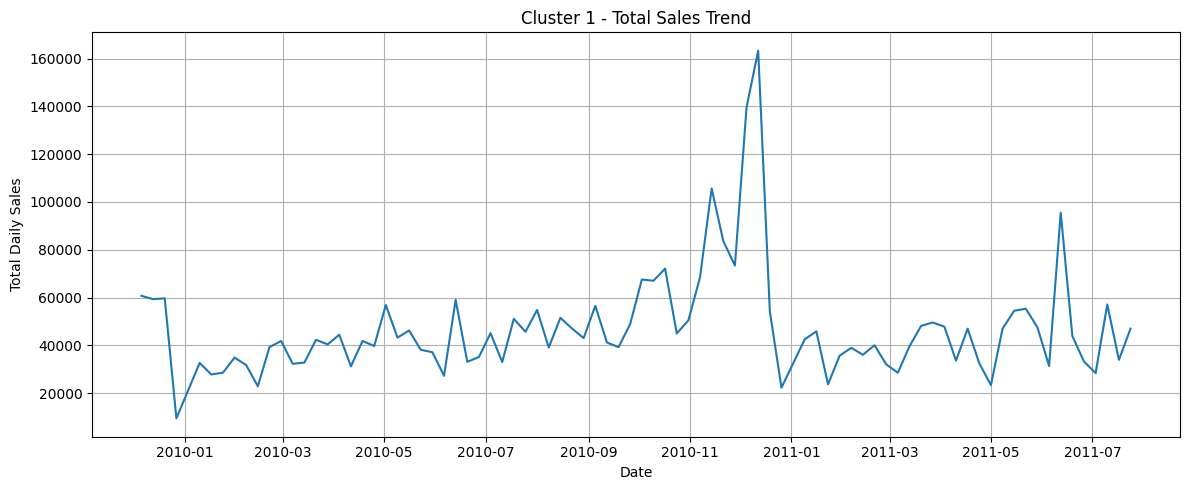

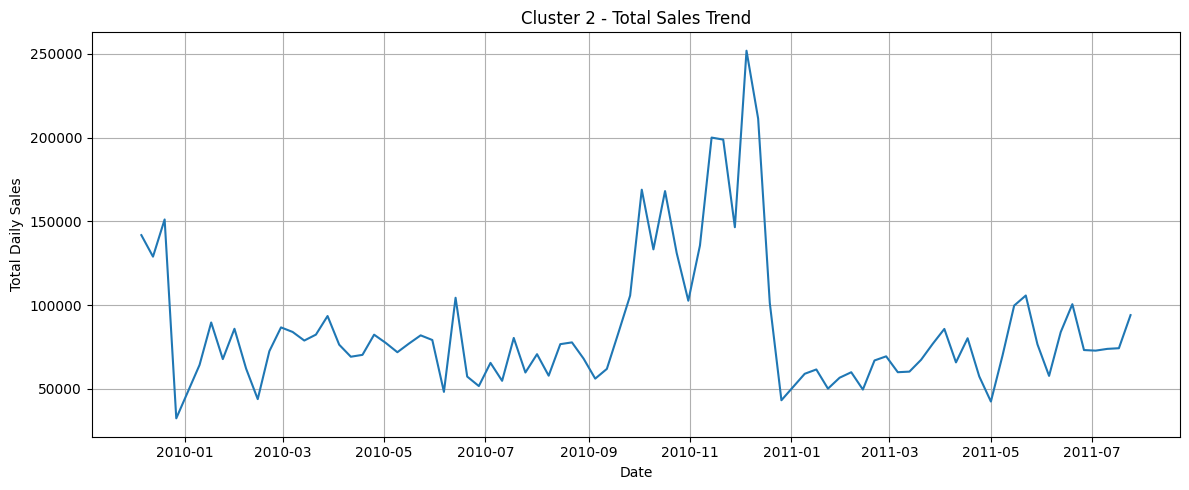

In [5]:
# Step 6: Visualization - sales trend
for c in range(2):
    cluster_products = train_sales[train_sales["cluster"] == c].index

    cluster_sales = daily_sales[cluster_products].loc[:split_date].sum(axis=1)

    plt.figure(figsize=(12, 5))
    plt.plot(cluster_sales.index, cluster_sales.values, color='tab:blue')
    plt.title(f"Cluster {c+1} - Total Sales Trend")
    plt.xlabel("Date")
    plt.ylabel("Total Daily Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 7: Save clustering result
product_clusters = train_sales[["cluster"]]
product_clusters.to_csv("product_cluster_labels_k2.csv")

## Agglomerative (k=5)

In [ ]:
# Step 1: Read data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]

# Step 2: Aggregate by day
df.set_index("InvoiceDate", inplace=True)
daily_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 3: Split train/test (80%:20%)
split_date = daily_sales.index[int(len(daily_sales) * 0.8)]
train_sales = daily_sales.loc[:split_date].T

# Step 4: Standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_sales)

# Step 5: Agglomerative clustering（k=5）
cluster_model = AgglomerativeClustering(n_clusters=5)
train_sales["cluster"] = cluster_model.fit_predict(X_scaled)

In [ ]:
# Step 6: Visualization - count clusters
cluster_counts = train_sales["cluster"].value_counts().sort_index()
cluster_counts

In [ ]:
# Step 6: Visualization - sales trend
for c in range(5):
    cluster_products = train_sales[train_sales["cluster"] == c].index

    cluster_sales = daily_sales[cluster_products].loc[:split_date].sum(axis=1)

    plt.figure(figsize=(12, 5))
    plt.plot(cluster_sales.index, cluster_sales.values, color='tab:blue')
    plt.title(f"Cluster {c+1} - Total Sales Trend")
    plt.xlabel("Date")
    plt.ylabel("Total Daily Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 7: Save result
product_clusters = train_sales[["cluster"]]
product_clusters.to_csv("product_cluster_labels_a5.csv")

## Kmeans (k=5)

In [ ]:
# Step 1: Read Data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]

# Step 2: Aggregate by day
df.set_index("InvoiceDate", inplace=True)
daily_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 3: Split train/test (80%:20%)
split_date = daily_sales.index[int(len(daily_sales) * 0.8)]
train_sales = daily_sales.loc[:split_date].T

# Step 4: Standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_sales)

# Step 5: Kmeans Clustering（k=5）
cluster_model = KMeans(n_clusters=5, random_state=42)
train_sales["cluster"] = cluster_model.fit_predict(X_scaled)

In [ ]:
# Step 6: Visualization - count clusters
cluster_counts = train_sales["cluster"].value_counts().sort_index()
cluster_counts

In [ ]:
# Step 6: Visualization - sales trend
for c in range(5):
    cluster_products = train_sales[train_sales["cluster"] == c].index

    cluster_sales = daily_sales[cluster_products].loc[:split_date].sum(axis=1)

    plt.figure(figsize=(12, 5))
    plt.plot(cluster_sales.index, cluster_sales.values, color='tab:blue')
    plt.title(f"Cluster {c+1} - Total Sales Trend")
    plt.xlabel("Date")
    plt.ylabel("Total Daily Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Step 7: Save clustering result
product_clusters = train_sales[["cluster"]]
product_clusters.to_csv("product_cluster_labels_k5.csv")

## Description Length

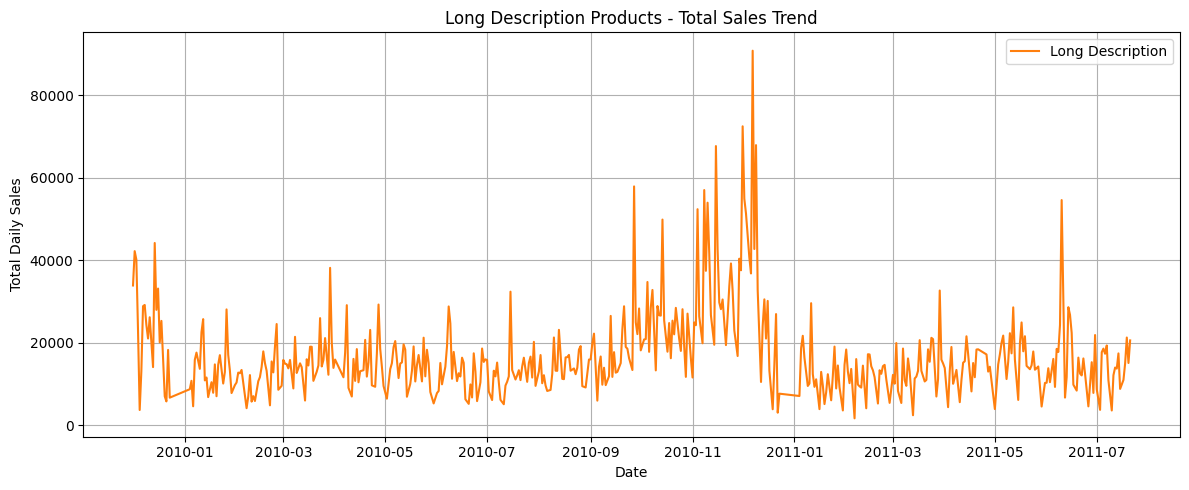

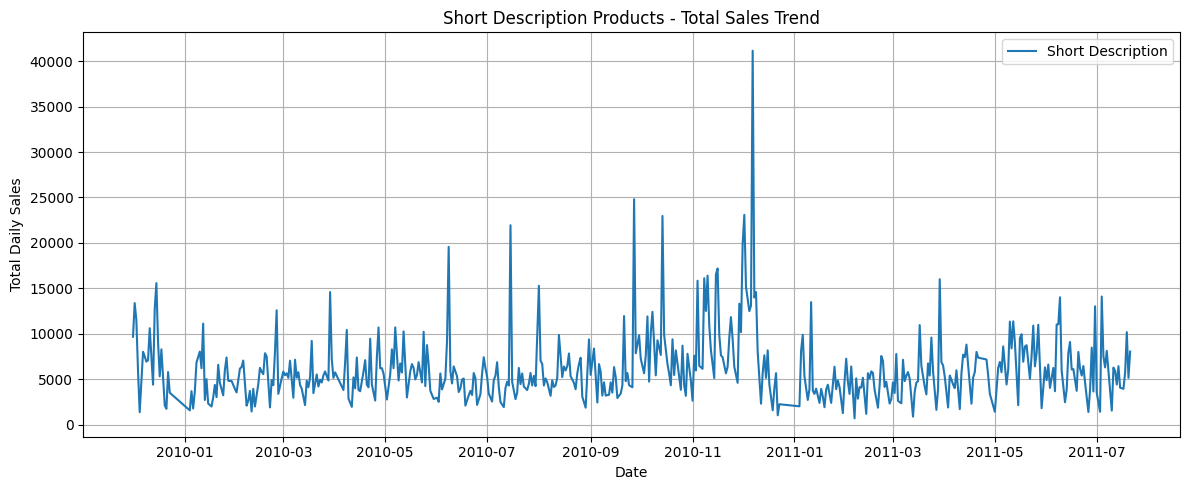

In [ ]:
# Step 1: 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 2: 读取数据并生成销售列
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]

# Step 3: 计算 Description 长度并创建标签
df["Description"] = df["Description"].astype(str)
df["DescriptionLength"] = df["Description"].apply(len)
df["IsLongDescription"] = df["DescriptionLength"] > 23

# Step 4: 按 StockCode 聚合标签（每个产品一个标签）
product_labels = df.groupby("StockCode")["IsLongDescription"].first().to_frame()

# Step 5: 构建产品每日销售矩阵
df.set_index("InvoiceDate", inplace=True)
daily_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)

# Step 6: 时间切分
split_date = daily_sales.index[int(len(daily_sales) * 0.8)]
train_sales = daily_sales.loc[:split_date].T

# Step 7: 合并标签
train_sales = train_sales.join(product_labels)

# Step 8: 可视化每类产品的总销售趋势
for group in [True, False]:
    group_products = train_sales[train_sales["IsLongDescription"] == group].index
    group_sales = daily_sales[group_products].loc[:split_date].sum(axis=1)

    plt.figure(figsize=(12, 5))
    plt.plot(group_sales.index, group_sales.values, label=f"{'Long' if group else 'Short'} Description", color='tab:orange' if group else 'tab:blue')
    plt.title(f"{'Long' if group else 'Short'} Description Products - Total Sales Trend")
    plt.xlabel("Date")
    plt.ylabel("Total Daily Sales")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Step 9: 保存标签
product_labels.to_csv("product_description_length_labels.csv")

In [ ]:
# Step 1: Read data
df = pd.read_csv("cleaned_retail_dataset.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Sales"] = df["Quantity"] * df["Price"]
df.set_index("InvoiceDate", inplace=True)

# Step 2: Aggregate by day
weekly_sales = df.groupby([pd.Grouper(freq="W"), "StockCode"])["Sales"].sum().unstack(fill_value=0)


# Step 3: Split train/test（80%:20%）
split_date = weekly_sales.index[int(len(weekly_sales) * 0.8)]
train_sales = weekly_sales.loc[:split_date].T
test_sales = weekly_sales.loc[split_date:].T

# Step 4: Standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_sales)

# Step 5: Clustering
from tqdm import tqdm
results = []
k_range = range(2, 11)

## Kmeans & Agglomerative
for method in ["kmeans", "agglomerative"]:
    for k in k_range:
        if method == "kmeans":
            model = KMeans(n_clusters=k, random_state=42)
        else:
            model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X_train_scaled)
        score = silhouette_score(X_train_scaled, labels)
        results.append({"method": method, "k": k, "silhouette": score})

## DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels = dbscan.fit_predict(X_train_scaled)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
if n_clusters > 1:
    mask = labels != -1
    score = silhouette_score(X_train_scaled[mask], labels[mask])
    results.append({"method": "dbscan", "k": n_clusters, "silhouette": score})

# Result
results_df = pd.DataFrame(results)
results_df.sort_values(by="silhouette", ascending=False, inplace=True)
print(results_df)